In [1]:
import os
import sys
import time
import glob
import datetime
import sqlite3
import numpy as np
import hdf5getters as GETTERS
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.35:7077") \
        .appName("r")\
        .config("spark.executor.cores",2)\
        .config("spark.dynamicAllocation.enabled", False) \
        .config("spark.shuffle.service.enabled", False) \
        .getOrCreate()
        
sc = spark_session.sparkContext

In [2]:
msd_subset_path='/home/ubuntu/MillionSongSubset/'
msd_subset_data_path=os.path.join(msd_subset_path,'data')
msd_subset_addf_path=os.path.join(msd_subset_path,'AdditionalFiles')
msd_code_path='/home/ubuntu/MSongsDB'
dbfile = '/home/ubuntu/MSongsDB/Tasks_Demos/SQLite/track_metadata.db'
sys.path.append(os.path.join(msd_code_path,'PythonSrc'))

def apply_to_all_files(basedir,func=lambda x: x,ext='.h5'):
    cnt = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        cnt += len(files)
        for f in files :
            func(f)       
    return cnt

print('number of song files:',apply_to_all_files(msd_subset_data_path))

number of song files: 10000


In [3]:
all_the_info = set()

def func_to_get_all_the_info(filename):
    h5 = GETTERS.open_h5_file_read(filename)
    year = GETTERS.get_year(h5)
    hotness = GETTERS.get_song_hotttnesss(h5)
    artist_hotness = GETTERS.get_artist_hotttnesss(h5)
    loudness = GETTERS.get_loudness(h5)
    tempo = GETTERS.get_tempo(h5)
    key = GETTERS.get_key(h5)
    
    all_the_info.add((year, hotness, artist_hotness, loudness, tempo, key))
    h5.close()

apply_to_all_files(msd_subset_data_path,func=func_to_get_all_the_info)

10000

In [4]:
rdd = sc.parallelize(list(all_the_info))
rdd1 = rdd.map(lambda x: list(x)).map(lambda y: ([int(y[0]), y[1], y[2], y[3], y[4], y[5]]))
rdd2 = rdd1.filter(lambda x: len(x) == 6)\
    .filter(lambda x: type(x[0]) == int and x[0] >= 1980)\
    .filter(lambda x: x[1] > 0)
rdd3 = rdd2.map(lambda x: (x[0], [x[1], x[2], x[3], x[4], x[5], 1]))

[(1988, [0.5473248320344863, 0.46682699252718746, -11.356, 91.328, 7, 1]),
 (2006, [0.6049633995508662, 0.42978028579125227, -4.576, 125.987, 9, 1]),
 (2002, [0.3603705827121406, 0.41478065907349704, -10.215, 216.023, 8, 1]),
 (2000, [0.4287022625232594, 0.4494236346936823, -5.031, 81.224, 6, 1]),
 (1993, [0.4507622416414992, 0.42495308411251165, -35.277, 152.084, 8, 1])]

In [32]:
rdd4 = rdd3.reduceByKey(lambda a,b: [a[0]+b[0], a[1]+b[1], a[2]+b[2], a[3]+b[3], a[4]+b[4], a[5]+b[5]])\
    .map(lambda x: (x[0], [x[1][0]/x[1][5], x[1][1]/x[1][5], x[1][2]/x[1][5], x[1][3]/x[1][5], x[1][4]/x[1][5]]))
rdd4.cache()

PythonRDD[58] at RDD at PythonRDD.scala:53

In [54]:
import math

def sigmoid(alist):
    listMax = float(max(alist))
    alist = [i/listMax for i in alist]
    alist = [1/(1+math.exp(-i)) for i in alist]
    return alist

time = sorted(rdd4.map(lambda x: x[0]).collect())
song_hotness = sigmoid(sorted(rdd4.map(lambda x: x[1][0]).collect()))
artist_hotness = sigmoid(sorted(rdd4.map(lambda x: x[1][1]).collect()))
loudness = sigmoid(sorted(rdd4.map(lambda x: x[1][2]).collect()))
tempo = sigmoid(sorted(rdd4.map(lambda x: x[1][3]).collect()))

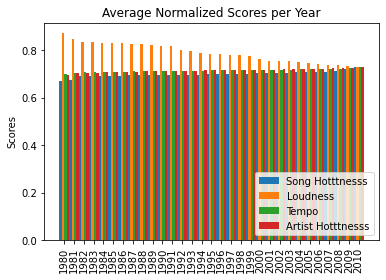

In [82]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(time))
width = 1

fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/8, song_hotness, width/4, label='Song Hotttnesss')
rects3 = ax.bar(x - width/8, loudness, width/4, label='Loudness')
rects4 = ax.bar(x + width/8, tempo, width/4, label='Tempo')
rects2 = ax.bar(x + 3*width/8, artist_hotness, width/4, label='Artist Hotttnesss')

ax.set_ylabel('Scores')
ax.set_title('Average Normalized Scores per Year')
ax.set_xticks(x)
ax.set_xticklabels(time, rotation = 90)

ax.legend(loc = 'lower right')

plt.show()


In [83]:
#sc.stop()